In [11]:
#cell 1 Setup
!pip install datasets --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import re
import time
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [12]:
#cell 2 Load IMDB & Build Vocabulary
imdb = load_dataset("imdb")

def basic_tokenizer(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

counter = Counter()
for text in imdb["train"]["text"]:
    counter.update(basic_tokenizer(text))

MAX_VOCAB_SIZE = 20000
most_common = counter.most_common(MAX_VOCAB_SIZE)
itos = ["<pad>", "<unk>"] + [word for word, _ in most_common]
stoi = {word: idx for idx, word in enumerate(itos)}

PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"]

def numericalize(tokens):
    return [stoi.get(token, UNK_IDX) for token in tokens]

def collate_batch(batch):
    labels, texts = [], []
    for example in batch:
        labels.append(example["label"])
        token_ids = torch.tensor(numericalize(basic_tokenizer(example["text"])), dtype=torch.long)
        texts.append(token_ids)
    labels = torch.tensor(labels, dtype=torch.long)
    texts = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    return texts, labels

train_loader = DataLoader(imdb["train"], batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(imdb["test"], batch_size=32, shuffle=False, collate_fn=collate_batch)

print("Vocab size:", len(itos))


Vocab size: 20002


In [13]:
#cell 3 LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (h, _) = self.lstm(embedded)
        out = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        return self.fc(out)

model = LSTMClassifier(len(itos)).to(device)
print(model)


LSTMClassifier(
  (embedding): Embedding(20002, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [14]:
#cell 4 Training & Evaluation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
    return total_loss/len(loader), correct/len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
    return total_loss/len(loader), correct/len(loader.dataset)

EPOCHS = 5
best_acc = 0
history = {"train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    elapsed = time.time() - t0

    history["train_acc"].append(train_acc*100)
    history["val_acc"].append(val_acc*100)

    print(f"Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc*100:.2f}% | "
          f"ValLoss={val_loss:.4f} Acc={val_acc*100:.2f}% | Time={elapsed:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc

print("Best Test Accuracy:", best_acc*100)


Epoch 1: TrainLoss=0.6414 Acc=62.16% | ValLoss=0.5618 Acc=71.88% | Time=26.5s
Epoch 2: TrainLoss=0.5700 Acc=70.66% | ValLoss=0.5650 Acc=70.24% | Time=26.7s
Epoch 3: TrainLoss=0.4706 Acc=77.90% | ValLoss=0.4596 Acc=80.06% | Time=25.6s
Epoch 4: TrainLoss=0.3555 Acc=85.42% | ValLoss=0.4379 Acc=81.02% | Time=25.6s
Epoch 5: TrainLoss=0.3408 Acc=85.44% | ValLoss=0.4561 Acc=78.63% | Time=25.9s
Best Test Accuracy: 81.016


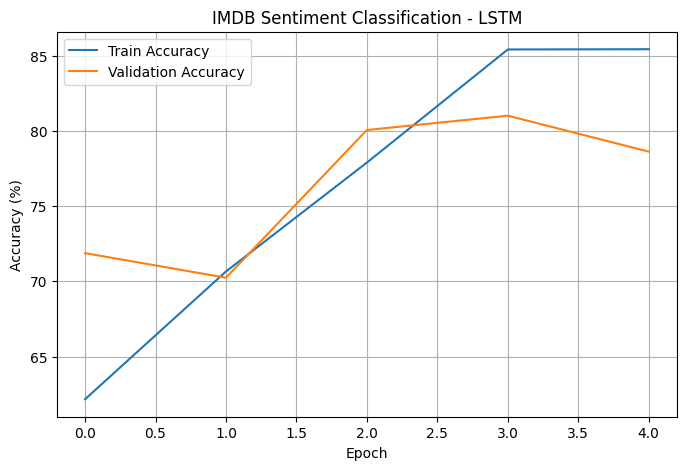

In [15]:
#cell 5 graph
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("IMDB Sentiment Classification - LSTM")
plt.legend()
plt.grid(True)
plt.show()
